In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; margin-left:auto;margin-right:auto;}</style>"))
display(HTML("<style>div.text_cell { max-width:1000px !important; margin:auto;}</style>"))
display(HTML("<style>.input { max-width:1100px !important; width:95%; margin:auto;}</style>"))
display(HTML("<style>.output { max-width:100% !important; margin:auto; align-items:center;}</style>"))
# display(HTML("<style>.output_subarea { max-width:80%; width:1000px; margin:auto}</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

from interp import interpolator, tomo_interpolator
import RegTomoRecon as rtr
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

filename = 'data/shepplogan'
if 'recon' not in locals():
    recon = {}


%matplotlib notebook
def figure(name='tmp', figsize=(9.5,6), **kwargs):
    plt.close(name)
    return plt.figure(name, figsize=figsize, **kwargs)
def show(): plt.tight_layout(); F = plt.gcf(); F.canvas.draw(); F.canvas.flush_events()

# Define phantoms

<IPython.core.display.Javascript object>


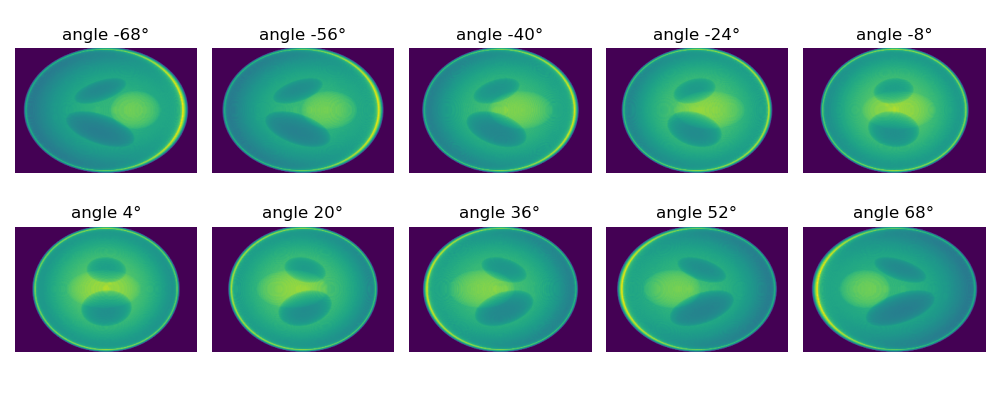

In [3]:
def phantom(size, modified=False, dtype='float32'):
    # The shepp-logan ellipses
    params = np.array(
       [[2.00, .6900, .9200, .810, 0.0000, 0.0000, 0.00, 0.0, 0, 0],
        [-.98, .6624, .8740, .780, 0.0000, -.0184, 0.00, 0.0, 0, 0],
        [-.02, .1100, .3100, .220, 0.2200, 0.0000, 0.00, -18, 0, 0],
        [-.02, .1600, .4100, .280, -.2200, 0.0000, 0.00, +18, 0, 0],
        [0.01, .2100, .2500, .410, 0.0000, 0.3500, 0.00, 0.0, 0, 0],
        [0.01, .0460, .0460, .050, 0.0000, 0.1000, 0.00, 0.0, 0, 0],
        [0.01, .0460, .0460, .050, 0.0000, -.1000, 0.00, 0.0, 0, 0],
        [0.01, .0460, .0230, .050, -.0800, -.6050, 0.00, 0.0, 0, 0],
        [0.01, .0230, .0230, .020, 0.0000, -.6060, 0.00, 0.0, 0, 0],
        [0.01, .0230, .0460, .020, 0.0600, -.6050, 0.00, 0.0, 0, 0]]
    )
    if modified:
        params[:,0] = [1.0, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    else:
        params[:,0] /= 2 # normalise max=1
    
    shape = (size,)*3
    obj = np.zeros(shape, dtype=dtype)

    A = params[:,0].ravel()
    R = np.concatenate([_rotation_matrix(p[-3:])[None,:,:] for p in params],axis=0)
    M = np.concatenate([p[4:7][None,:] for p in params],axis=0)
    S = np.concatenate([p[1:4][None,:] for p in params],axis=0)
    _ellipsoid(*([np.linspace(-1,1,size)]*3), A,R,M,S, obj)
    return obj

from numba import jit, prange
@jit(parallel=True)
def _ellipsoid(X,Y,Z,A,R,M,S,out):
    for i0 in prange(X.size):
        for i1 in range(Y.size):
            for i2 in range(Z.size):
                for j in range(R.shape[0]): # for each ellipsis
                    n = 0
                    for k in range(3): # 3D vectors
                        n += ((R[j,k,0]*X[i0]+R[j,k,1]*Y[i1]+R[j,k,2]*Z[i2] - M[j,k])/S[j,k])**2
                    if n <= 1:
                        out[i0,i1,i2] += A[j]
                
def _rotation_matrix(p):
    cphi, sphi = [f(np.radians(p[0])) for f in (np.cos, np.sin)]
    ctheta, stheta = [f(np.radians(p[1])) for f in (np.cos, np.sin)]
    cpsi, spsi = [f(np.radians(p[2])) for f in (np.cos, np.sin)]
    return np.asarray([[cpsi * cphi - ctheta * sphi * spsi, cpsi * sphi + ctheta * cphi * spsi, spsi * stheta],
             [-spsi * cphi - ctheta * sphi * cpsi, -spsi * sphi + ctheta * cphi * cpsi, cpsi * stheta],
             [stheta * sphi, -stheta * cphi, ctheta]])


angles = np.arange(-68,72,4)
subind = np.linspace(0,len(angles)-1,10).astype(int)
GT = phantom(256, modified=True)
GT = GT[GT.max(axis=(1,2))>0]
data = rtr.tomo_data(np.zeros((GT.shape[0], len(angles), GT.shape[1])),
                            angles, degrees=True, tilt_axis=0, stack_dim=1)
data = data.getOperator(vol_shape=GT.shape, backend='astra', GPU=True)(GT).reshape(GT.shape[0],-1,GT.shape[1])
GT = (GT/data.max()).astype('float32')
data = np.require(data.transpose((1,0,2))/data.max(), requirements='C')

figure('data', figsize=(10,4))
for i,j in enumerate(subind):
    plt.subplot(2,5,i+1).imshow(data[j],vmin=0,vmax=1,origin='lower'); plt.title('angle %d°'%angles[j]); plt.axis('off')
show()

# Example samples

In [4]:
def Lissajous(a,b, threshold=0):
    # Lissajous curves are formed of two sinosoids
    
    if threshold==0:
        t = [0,2*np.pi]
    else:
        # compute times between 0 and 2pi where we want |cos(t)| <= 1-threshold
        t0,i = np.arccos(1-threshold), np.arange(np.ceil(2*max(a,b))+2)[:,None]
        t0 = np.concatenate( (t0+np.pi*i, -t0+np.pi*(i+1)), axis=1)
        ta, tb = t0/a, t0/b
        ta, tb = ta[ta[:,0]<2*np.pi], tb[tb[:,0]<2*np.pi]
        
        t = []
        while len(ta)>0 and len(tb)>0:
            if tb[0,0] < ta[0,0]:
                tb, ta = ta, tb # ta is the interval starting first
            if ta[0,1]<tb[0,0]: # first interval ends before second
                ta = ta[1:]
            elif ta[0,1]>tb[0,1]: # first interval ends after second
                t.append(tb[0])
                tb = tb[1:]
            else:
                t.append(np.array([tb[0,0],ta[0,1]]))
                ta = ta[1:]
        if len(t)==0:
            raise ValueError('threshold is too high, no valid times found')
        t[-1][1] = min(2*np.pi,t[-1][1])
    t = np.array(t).reshape(-1,2)
        
    def lissajous(T):
        n = int(np.ceil(T/t.shape[0])) # number of points per segment
        points = []
        for tt in t:
            points.append(np.concatenate((
                np.cos(a*np.linspace(*tt,n))[:,None],
                np.cos(b*np.linspace(*tt,n))[:,None]), axis=1))
        return .5+.5/(1-threshold)*np.concatenate(points, axis=0)[:T]
    return lissajous

def Uniform():
    # Uniform point sampling
    def rand(T):
        np.random.seed(1)
        return np.random.rand(T,2)
    return rand

def Grid():
    # Uniform grid sampling
    def rand(T):
        n = int(round(T**.5)) # T samples is roughly an nxn grid
        m = np.linspace(0,1,n+2)[1:-1]
        x,y = np.meshgrid(m,m)
        return np.concatenate((x.reshape(-1,1),y.reshape(-1,1)), axis=1)
    return rand

def Lines(n):
    # Samples are taken down random straight lines of length n pixels
    def lines(T): # T is number of samples
        np.random.seed(1)
        n_curves = T//n+1
        curves = np.random.rand(n_curves,1,2), np.random.rand(n_curves,1,2) # random start and end points
        for i in range(n_curves):
            tmp = [(0,0),(0,1),(1,0),(1,1)]
            for j in range(2):
                k = np.random.randint(4-j)
                k = tmp.pop(k)
                curves[j][i,0,k[0]] = k[1]
        curves = curves[0] + np.linspace(0,1,n)[None,:,None]*(curves[1]-curves[0])
        return curves.reshape(-1,2)[:T]
    return lines


## Example curves

<IPython.core.display.Javascript object>


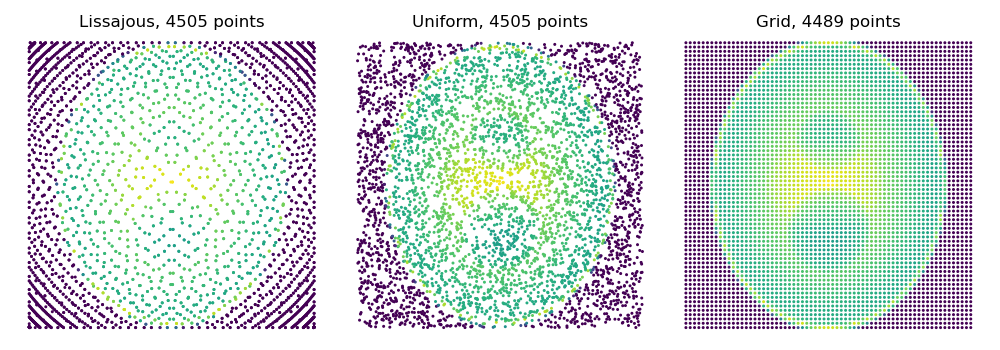

In [5]:
T = data[0].size//10 # 10% sampling schemes
CURVES = (('Lissajous',Lissajous(70,71,.2)), ('Uniform', Uniform()), ('Grid', Grid()))
param = {
    'order': 1, 'iters':2, 'weight':4, 'TGV': False, # parameters for inpainting
    'iters_indirect':3, 'weight_indirect': 3, # parameters for indirect reconstruction
    'iters_direct': 4, 'weight_direct': 4 # parameters for direct reconstruction
}
param = {
    'order': 1, 'iters':4, 'weight':3, 'TGV': True, # parameters for inpainting
    'iters_indirect':3, 'weight_indirect': 3, # parameters for indirect reconstruction
    'iters_direct': 4, 'weight_direct': 4 # parameters for direct reconstruction
}

figure('Samples',(10,3.5))
D = data[subind[len(subind)//2]]
ax = []
for i,(s,f) in enumerate(CURVES):
    L = f(T); I = interpolator(D.shape, L)
    ax = plt.subplot(1,3,i+1).scatter(I.image[:,1],I.image[:,0], s=6e3/T, c=I(D), vmin=D.min(), vmax=D.max()); 
    plt.title(s+', %d points'%L.shape[0]); plt.axis('off'); plt.axis('equal')
show()

## Data interpolation

In [6]:
# this takes about 1h
for i,(s,f) in enumerate(CURVES):
    myfilename = filename + '_inpaint_%s_%d_%d_%d'%(s, param['order'],param['iters'],param['weight'])
    if param['TGV']:
        myfilename += '_TGV'
    I = interpolator(data.shape[1:], f(T)).getOperator()
    try:
        recon[s] = np.load(myfilename+'.npz')['recon'].astype('float32')
    except Exception:
#         raise
        recon[s] = recon.get(s,[])
        if len(recon[s])==len(angles):
            recon[s] = []
    for j in tqdm(range(len(angles)), desc=s):
        D = data[j]
        if len(recon[s])>j:
            continue
        if param['TGV']:
            alg = rtr.TGV(D.shape, weight=np.array([3,1/3])*10**(-param['weight']), op=I)
            recon[s].append(alg.run(data=I(D), maxiter=3*10**param['iters'], steps='ada', callback='silent').astype('float32'))

        else:
            alg = rtr.TV(D.shape, order=param['order'], op=I, alg='SplitBregman')
            recon[s].append(alg.run(data=I(D), maxiter=3*10**param['iters'], weight=10**(-param['weight']), tau=10, callback='silent').astype('float32'))

    #             alg = rtr.SmoothTV(shape=D.shape, order=param['order'], op=I, eps=1e-5)
    #             recon[s].append(alg.run(data=I(D), maxiter=10**param['iters'], weight=10**(-param['weight']), callback='silent').astype('float32'))
    recon[s] = np.array(recon[s])
                
    np.savez_compressed(myfilename,recon=recon[s])

Lissajous:   0%|          | 0/35 [00:00<?, ?it/s]

Uniform:   0%|          | 0/35 [00:00<?, ?it/s]

Grid:   0%|          | 0/35 [00:00<?, ?it/s]

In [7]:
# j = subind[5]
# D = data[j]
# I = interpolator(D.shape, CURVES[0][1](T))
# # D = data[j,200:300,200:300]
# # I = interpolator(D.shape, Lissajous(20,21,.45)(T//25))
# # I = interpolator(D.shape, Uniform()(T//25))
# # tmp = [None]*3
# for i,tau in enumerate((10,3,1)):
#     alg = rtr.TV(D.shape, order=1, op=I.getOperator(), alg='SplitBregman')
#     tmp[i] = alg.run(data=I(D), maxiter=10*tau, callback_freq=100, weight=1e-3, tau=10, callback=('primal','gap','step'))[0]
# #     alg = rtr.SmoothTV(D.shape, order=1, op=I.getOperator(), eps=1e-5)

# #     alg = rtr.TGV(D.shape, weight=np.array([tau,1/tau])*1e-3, op=I.getOperator())
# #     tmp[i] = alg.run(data=I(D), maxiter=3*10**4, callback_freq=10**4, steps='ada', callback=('primal','gap','step'))[0]

#     tmp[i].shape = D.shape
# [print(('%.1e    '*3)%(abs(I(tmp[i]-D)).max(), abs(I(tmp[i]-D)).mean(), abs(tmp[i]-D).mean())) for i in range(3)]
# figure('tmp',(10,4))
# for i in range(3):
#     plt.subplot(2,3,i+1).imshow(tmp[i],origin='lower',vmin=0,vmax=1); plt.axis('off')
#     plt.subplot(2,3,i+4).imshow(abs(tmp[i]-D),origin='lower',vmin=0,vmax=.1); plt.axis('off')
# #     plt.scatter(I.image[:,1], I.image[:,0], s=6e3/T, c='r', vmin=D.min(), vmax=D.max())
# show()

# Interpolation plots

<IPython.core.display.Javascript object>


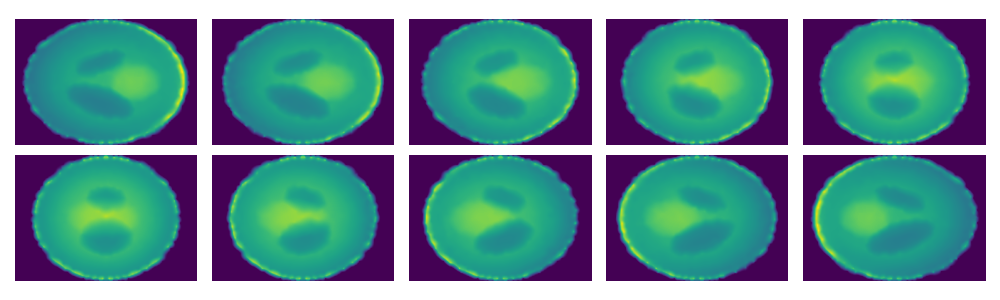

Data error: 1.4e-02    1.4e-02    1.4e-02    1.0e-02    1.0e-02    9.8e-03    9.9e-03    1.0e-02    1.3e-02    1.4e-02
GT error:   1.5e-02    1.6e-02    1.8e-02    1.8e-02    1.8e-02    1.8e-02    1.9e-02    1.8e-02    1.6e-02    1.5e-02


<IPython.core.display.Javascript object>


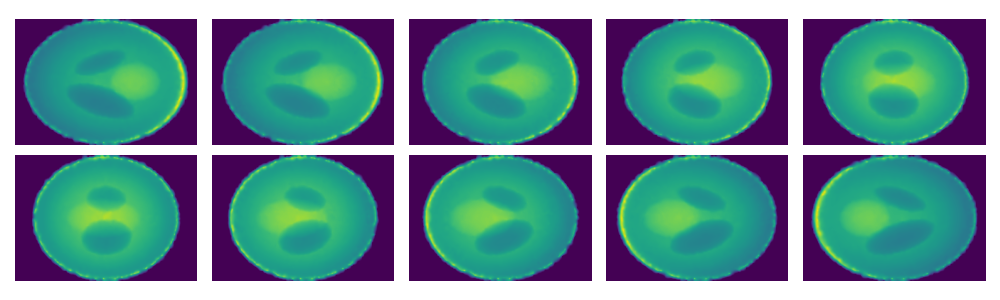

Data error: 1.3e-02    1.4e-02    1.2e-02    1.5e-02    1.7e-02    1.7e-02    1.6e-02    1.6e-02    1.4e-02    1.2e-02
GT error:   1.1e-02    1.2e-02    1.3e-02    1.3e-02    1.2e-02    1.2e-02    1.3e-02    1.3e-02    1.2e-02    1.1e-02


<IPython.core.display.Javascript object>


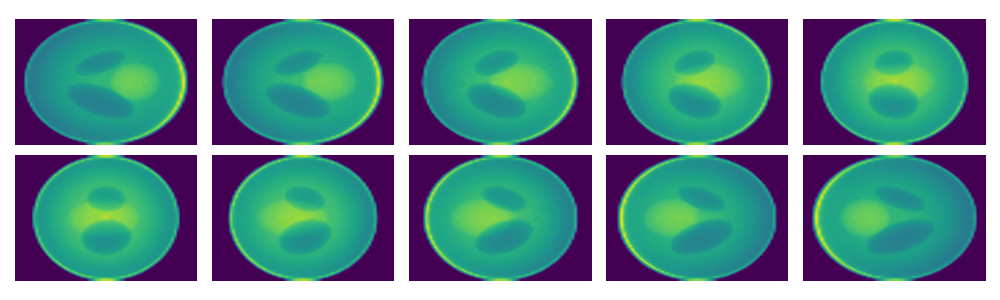

Data error: 9.4e-03    1.2e-02    1.1e-02    9.9e-03    7.8e-03    7.6e-03    9.7e-03    1.1e-02    1.1e-02    9.4e-03
GT error:   1.0e-02    1.1e-02    1.1e-02    1.1e-02    1.1e-02    1.1e-02    1.1e-02    1.1e-02    1.1e-02    1.0e-02


In [8]:
for (s,f) in CURVES:
    F = figure('%s inpainting'%s,(10,3))
    I = interpolator(data.shape[1:], f(T)).getOperator()
    for i,j in enumerate(subind):
        plt.subplot(2,5,i+1).imshow(recon[s][j],origin='lower',vmin=0,vmax=1,); plt.axis('off')
    print('Data error:', '    '.join('%.1e'%(abs(I(data[j]-recon[s][j])).max()/data[j].max()) for j in subind))
    print('GT error:  ', '    '.join('%.1e'%(abs(data[j]-recon[s][j]).mean()/data[j].max()) for j in subind))
    show()

# Error plots

<IPython.core.display.Javascript object>


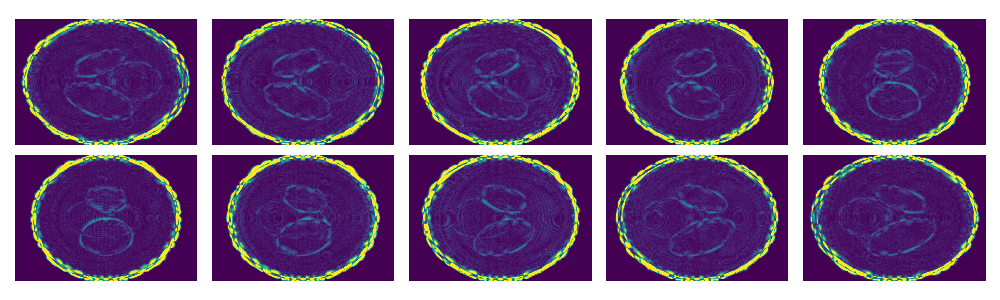

<IPython.core.display.Javascript object>


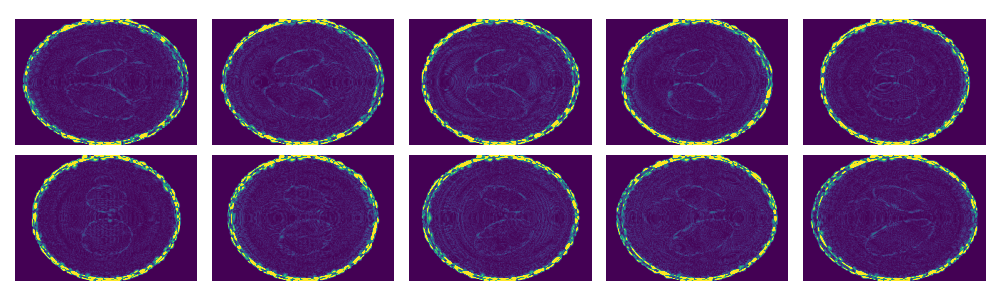

<IPython.core.display.Javascript object>


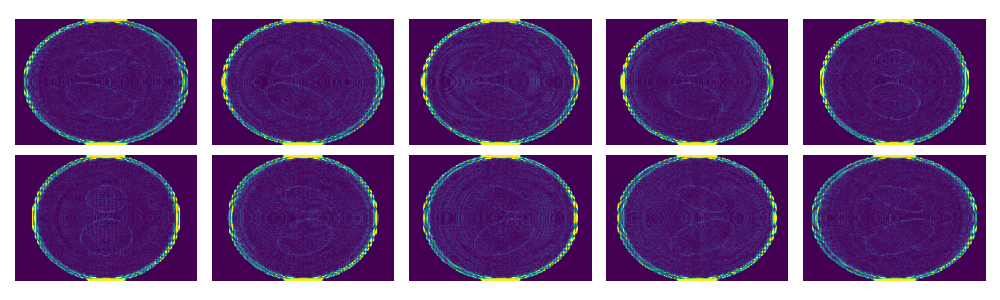

In [9]:
for (s,f) in CURVES:
    F = figure('%s error'%s,(10,3))
    for i,j in enumerate(subind):
        plt.subplot(2,5,i+1).imshow(abs(data[j]-recon[s][j]),vmin=0,vmax=1/10,origin='lower'); plt.axis('off')
    show()

# Indirect reconstructions

In [10]:
vol_shape = GT.shape # (512,40,512)

tomo_data = rtr.tomo_data(data, angles.astype(float), degrees=True, tilt_axis=1, stack_dim=0)
I = tomo_data.getOperator(vol_shape=vol_shape)

# fbp = rtr.FBP(filter='Ram-Lak', min_val=0, max_val=None)
# recon = fbp.run(data=tomo_data,op=I)
myfilename = filename + '_recon'
try:
    tomo_recon = np.load(myfilename+'.npz')['recon']
#     raise
except Exception:
    alg = rtr.TV(shape=vol_shape, order=1)
    tomo_recon = alg.run(data=tomo_data, op=I, maxiter=1000, callback_freq=100, weight=10**(-4),
                    steps='adaptive', callback=('primal','gap','violation','step'))[0].astype('float32')
#     alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-5)
#     tomo_recon = alg.run(x=tomo_recon.ravel(), data=tomo_data, op=I, maxiter=10**3, weight=10**(-4), 
#                                  callback_freq=100, callback=('primal','step'))[0].astype('float32')
    np.savez_compressed(myfilename,recon=tomo_recon)
recon['direct '] = recon['indirect '] = tomo_recon

In [11]:
# this takes about 2h
for (s,f) in CURVES:
    myfilename = filename + '_recon_indirect_%s_%d_%d_%d_%d'%(s, param['order'],param['iters_indirect'],param['weight'],param['weight_indirect'])
    if param['TGV']:
        myfilename += '_TGV'
    D = rtr.tomo_data(recon[s], angles.astype(float), degrees=True, tilt_axis=1, stack_dim=0)
    I = tomo_data.getOperator(vol_shape=vol_shape)

    try:
#         raise
        recon['indirect '+s] = np.load(myfilename+'.npz')['recon']
    except Exception:
        alg = rtr.TV(shape=vol_shape, order=1) # Always order=1 volume penalty
        recon['indirect '+s] = alg.run(data=D, op=I, maxiter=10**param['iters_indirect'], callback_freq=10**(param['iters_indirect']-1), weight=10**(-param['weight_indirect']),
                        steps='adaptive', callback=('primal','gap','violation','step'))[0].astype('float32')

#         alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-5)
#         recon['indirect '+s] = alg.run(x=tomo_recon.ravel(), data=D, op=I, maxiter=10**param['iters_indirect'], weight=10**(-param['weight_indirect']),
#                                      callback_freq=100, callback=('primal','step'))[0].astype('float32')

        np.savez_compressed(myfilename,recon=recon['indirect '+s])


# Direct reconstructions

In [12]:
# this takes under 2h

for (s,f) in CURVES:
    myfilename = filename + '_recon_direct_%s_%d_%d'%(s, param['iters_direct'],param['weight_direct'])
    D = np.concatenate([interpolator(data.shape[1:], f(T))(d)[None] for d in data], axis=0)
    I = tomo_interpolator(tomo_data.getOperator(vol_shape=vol_shape),
                          data.shape[1:], f(T)).getOperator()

    try:
#         raise
        recon['direct '+s] = np.load(myfilename+'.npz')['recon']
    except Exception:
        alg = rtr.TV(shape=vol_shape, order=1)
        recon['direct '+s] = alg.run(data=D, op=I, maxiter=10**param['iters_direct'], callback_freq=10**(param['iters_direct']-1), weight=10**(-param['weight_direct']),
                        steps='adaptive', callback=('primal','gap','violation','step'))[0].astype('float32')

#         alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-5)
#         recon['direct '+s] = alg.run(x=tomo_recon.ravel(), data=D, op=I, maxiter=10**param['iters_direct'], weight=10**(-param['weight_direct']), 
#                                      callback_freq=100, callback=('primal','step'))[0].astype('float32')

        np.savez_compressed(myfilename,recon=recon['direct '+s])
    


In [13]:
# # %load_ext line_profiler 
# alg = rtr.SmoothTV(shape=vol_shape, order=1, eps=1e-5, pos=False)
# tmp = lambda: alg.run(data=D, op=I, maxiter=50, callback_freq=10, weight=1e-4, steps='adaptive', callback='step')
# # tmp()
# %prun -s cumulative tmp()
# # %lprun tmp()
# from scipy.optimize.lbfgsb import _minimize_lbfgsb
# # %lprun -f _minimize_lbfgsb tmp()

# Plots for indirect/direct reconstructions respectively

<IPython.core.display.Javascript object>


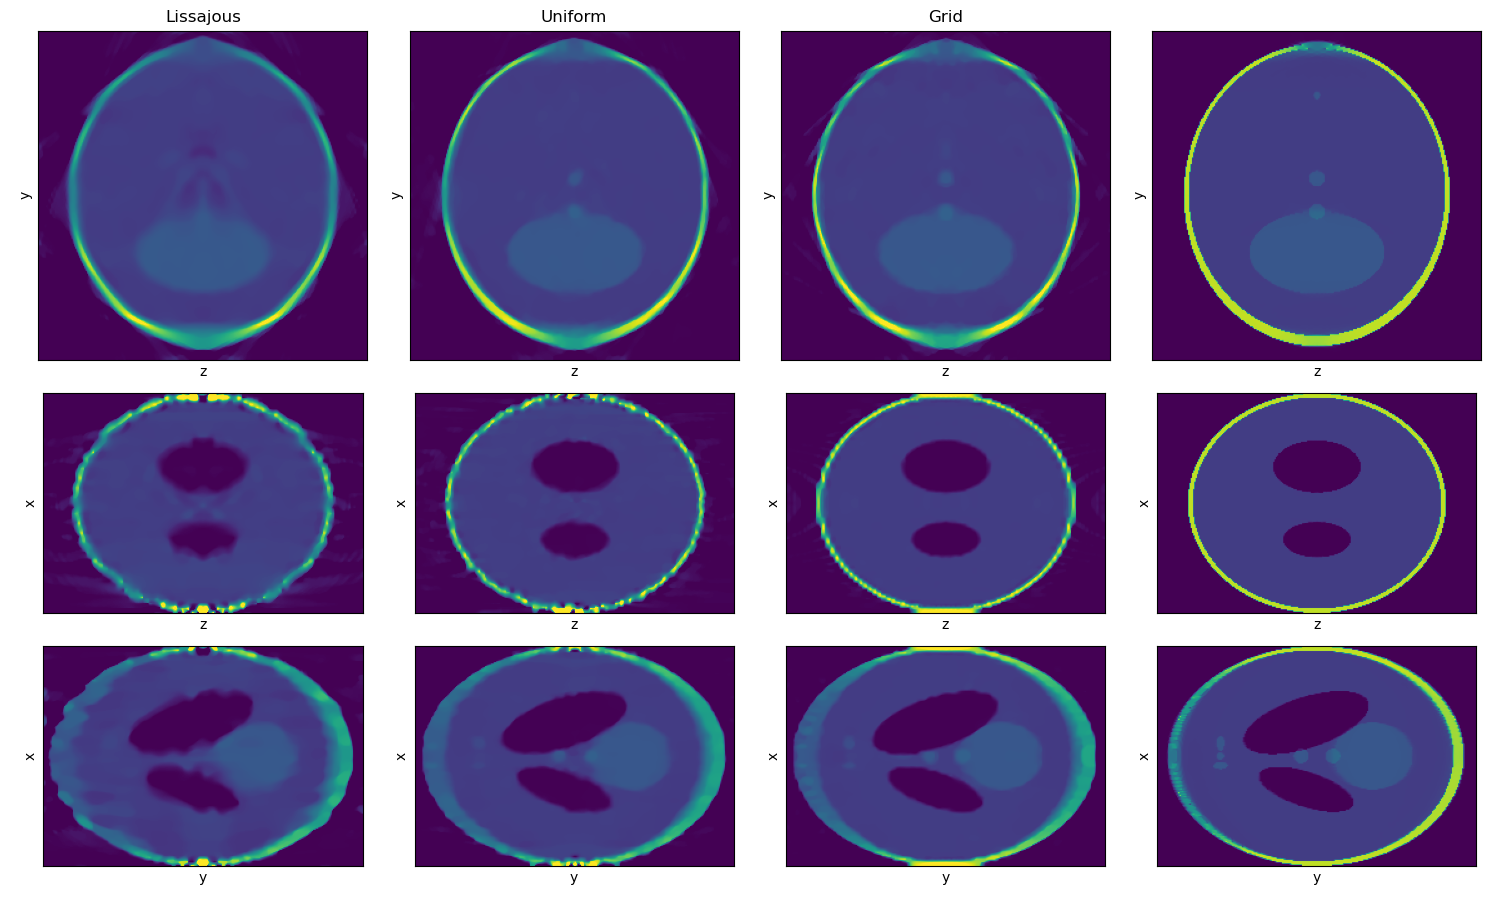

indirect  Lissajous 0.007493242147573915
indirect  Uniform 0.005291753364159445
indirect  Grid 0.003955329223304872
indirect   0.00031334403


<IPython.core.display.Javascript object>


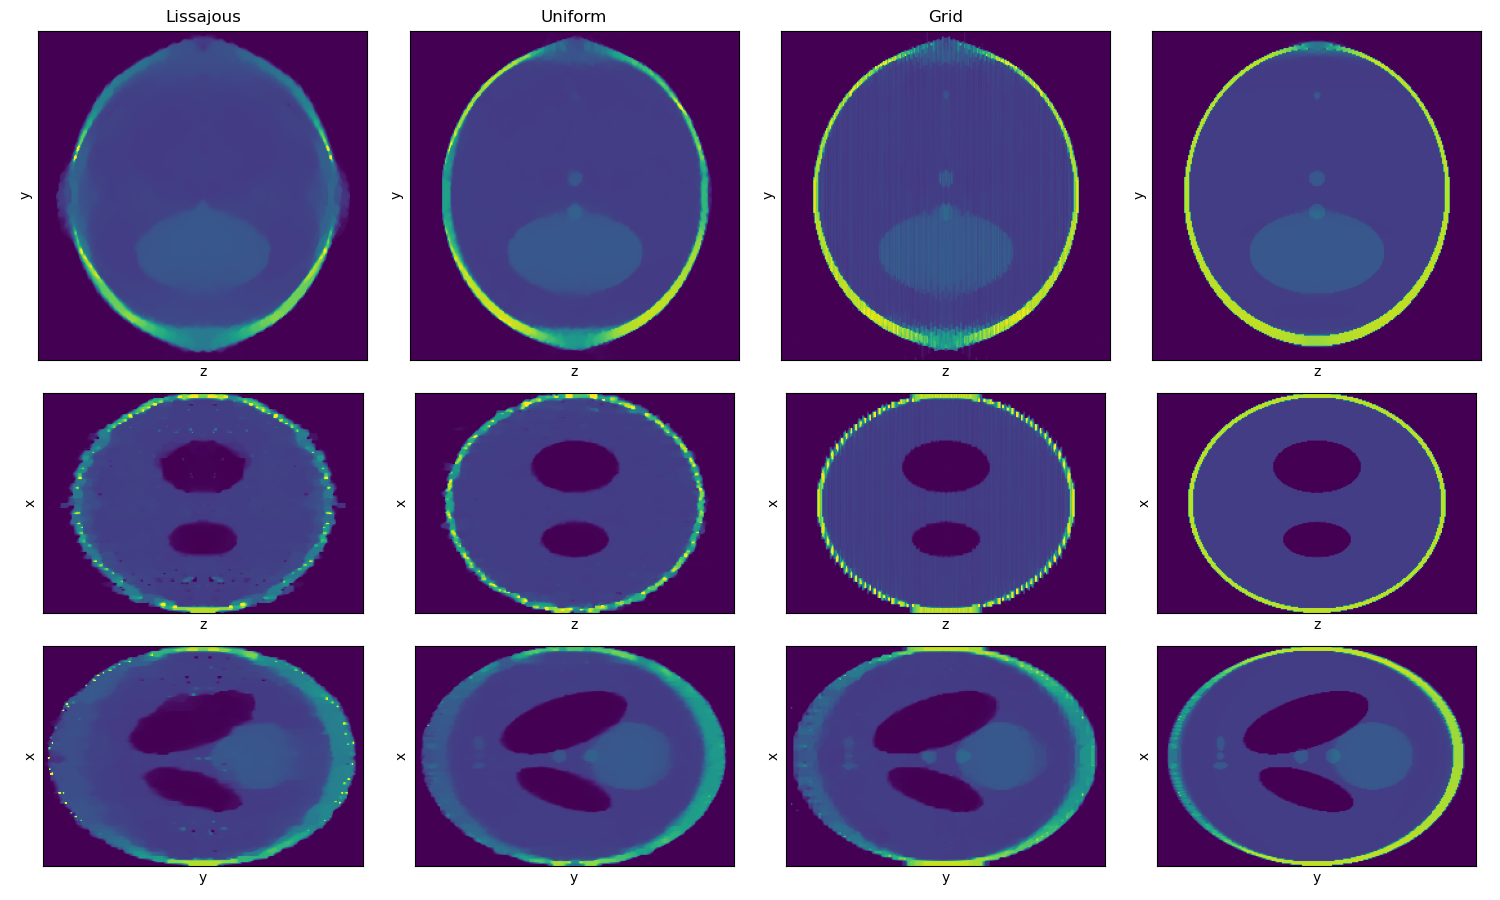

direct  Lissajous 0.0004708814157972518
direct  Uniform 0.0008630908409482213
direct  Grid 0.00041474001298825254
direct   0.00031334403


In [14]:
for tag in ('indirect ','direct '):
    F = figure(tag+'reconstructions',figsize=(15,9))
    ax = F.subplots(3,4,gridspec_kw={'height_ratios': [3,2,2]})
    for i, (s,f) in enumerate(CURVES+(('',None),)):
        R = recon[tag+s]
        aspect = ('equal','auto')[0]
        ax[0,i].set_title(s)
        ax[0,i].imshow(R[R.shape[0]//2], vmin=0, vmax=.015, aspect=aspect)
        ax[1,i].imshow(R[:,R.shape[1]//2], vmin=0, vmax=.015, aspect=aspect)
        ax[2,i].imshow(R[:,:,R.shape[2]//2], vmin=0, vmax=.015, aspect=aspect)
        for j in range(3):
    #         ax[j,i].imshow(R.sum(j), vmin=0, aspect=aspect)
#             ax[j,i].set_axis_off()
            ax[j,i].set_xticks([]); ax[j,i].set_xlabel('zzy'[j])
            ax[j,i].set_yticks([]); ax[j,i].set_ylabel('yxx'[j])
        
        if f is not None:
            D = np.concatenate([interpolator(data.shape[1:], f(T))(d)[None] for d in data], axis=0)
            I = tomo_interpolator(tomo_data.getOperator(vol_shape=vol_shape),data.shape[1:], f(T))
            print(tag, s, abs(I(R)-D).mean())
        else:
            D = rtr.tomo_data(data, angles.astype(float), degrees=True, tilt_axis=1, stack_dim=0)
            I = tomo_data.getOperator(vol_shape=vol_shape)
            print(tag, s, abs(I(R)-D.ravel()).mean())
            

    show()

In [15]:
# # trying to estimate the correct threshold
# figure()
# for s in recon:
#     if 'direct' in s:
#         plt.plot(np.percentile(recon[s].ravel(),np.arange(0,101)),label=s)
# plt.plot(np.percentile(GT.ravel(),np.arange(0,101)),label='GT')
# plt.xlabel('percentile'); plt.ylabel('threshold'); plt.legend();show()

In [16]:
# Computing confusion matrix of thresholded solution, roughly 90% sparsity
levels = np.array((0, 0,0.0028,0.014, 1)) # approximate heights of levelsets of ground-truth (with endpoints)
thresh = .5*(levels[1:]+levels[:-1]) # thresholds to approximate 
names = [tag+s for tag in ('indirect ','direct ') for (s,f) in CURVES+(('',None),)]

# Base: .2/0/.9
# Indirect 3: 5/.5/68, 4/.5/44, 3/.7/29
# Indirect 4: 5/.5/63, 3/.5/41, 3/.5/29
# TGV 3     : 4/1/41, 3/.5/26, 2/.4/18
# Direct 3: 5/.6/82, 3/.6/35, 2/.4/20
# Direct 4: 3/.7/55, 2/.6/23, 1/.5/16

# Computing confusion matrix
confusion = np.empty((2*len(thresh)-2,len(names)))
for i in range(len(thresh)-1):
#     I = (recon['direct ']>=thresh[i]) & (recon['direct ']<thresh[i+1])
    I = (GT>=thresh[i]) & (GT<thresh[i+1])
    for j,s in enumerate(names):
        J = (recon[s]>=thresh[i]) & (recon[s]<thresh[i+1])
        confusion[2*i,j],confusion[2*i+1,j] = (I*J).sum(), (I*(1-J)).sum()
    confusion[2*i:2*i+2] *= 100/I.sum()

padstr = lambda s, n: ' '*(n//2-len(s)//2) + s + ' '*(n-n//2-len(s)+len(s)//2)
linelen=(126-14-6)//2-1
print('_'*(14+2*linelen+3+7))
print(' '*11, end=' | ')
for tag in ('indirect ', 'direct '):
    print(padstr(tag,linelen), end='|')
print(' '*7+'|\n'+'_'*11, end='_|_')
for tag in ('indirect ', 'direct '):
    tmp = ''.join(padstr(s[len(tag):],linelen//len(CURVES)) for s in names if len(s)>9 and s.startswith(tag))
    print(tmp.replace(' ','_')+'_'*(linelen-len(tmp)),end='|')
print(padstr('base',7).replace(' ','_'),end='|')
for i,S in enumerate([a+' %.1f'%b for b in 100*levels[1:-1] for a in ('Found','Missed')]):
    print('\n%11s'%S, end=' | ')
    for tag in ('indirect ', 'direct '):
        j,tmp = 0,''
        for s in names:
            if len(s)>9 and s.startswith(tag):
                tmp += padstr('% 6.1f%%'%confusion[i,j], linelen//len(CURVES))
            j+=1
        print(tmp+' '*(linelen-len(tmp)),end='|')
    print(padstr('% 6.1f%%'%confusion[i,-1], 7),end='|')
    if i%2==1 and i<len(thresh):
        print('\n'+' '*11+' | ', end=2*(' '*linelen+'|')+' '*7+'|')


________________________________________________________________________________________________________________________________
            |                       indirect                      |                       direct                       |       |
____________|_____Lissajous_________Uniform___________Grid________|____Lissajous_________Uniform___________Grid________|_base__|
  Found 0.0 |        96.1%            97.4%            97.7%      |       96.8%            98.0%            98.6%      |  99.8%|
 Missed 0.0 |         3.9%             2.6%             2.3%      |        3.2%             2.0%             1.4%      |   0.2%|
            |                                                     |                                                    |       |
  Found 0.3 |        99.1%            99.5%            99.6%      |       99.3%            99.4%            99.5%      | 100.0%|
 Missed 0.3 |         0.9%             0.5%             0.4%      |        0.7%             0.6% 